In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae

In [3]:
# load libraries and set plot parameters

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = "serif"
# plt.rcParams['font.serif'] = "cm"
# plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [4]:
import roboclimate.util as rutil
import datetime as dt
import roboclimate.data_quality as rdq
import roboclimate.config as rconf

# Table of Contents

* [Introduction](#intro)
* [Models](#models)
* [Metrics](#metrics)
* [Data collection](#data_collection)
* [Data analysis](#data_analysis)
    * [Data quality](#data_quality)
    * [Actual vs Forecast](#actual_vs_forecast)
    * [Metrics comparison](#metrics_comparison)
    * [Cities comparison](#cities_comparison)

<a id="intro"></a>
# Introduction

Have you ever complained about the weatherman failing to predict the weather correctly?

That's the question we aim to answer here: how reliable are the weather forecasts?

To do so we compare the accuracy of different weather models ranging from a naive approach to sophisticated meteorological models.

The scope of this analysis is restricted to the **temperature** in five locations around the world, namely:

- London
- Madrid
- Sydney
- New York
- Sao Paulo

<a id="models"></a>
# Models


### Naive forecast

Consists in assuming that the next value is the same as the one of the last period.

The tricky part is to identify what the last value is. For instance, if we measure the temperature
every 3 hours and we want to predict the temperature today at 3pm, what is the last value: today's temperature at 12pm, yesterday's temperature at 3pm or maybe last year's temperature on the same day at 3pm?


### Average values

Following with the previous example, we could use the average of the temperature over the last 20
years on the same day at 3pm


### Meteorological models

Provided by [OpenWeather](https://openweathermap.org/technology)

<a id="metrics"></a>
# Metrics

Metrics are used to evaluate the accuracy of the models' predictions when compared to the actual values.


## Mean absolute scaled error (MASE)

Mean absolute scaled error is a measure of the precision of a model compared to the naive forecast.

It is calculated as the mean absolute error of the forecast values predicted by the model divided by the mean absolute error of the naive forecast.

Values greater than one indicate that the naive method performs better than the more sophisticated forecast methods.

### Example

If $t^1$ is the 1-day forecast made on _2020-11-22 18:00_ for _2020-11-23 18:00_, the naive forecast is the actual temperature on _2020-11-22 18:00_.

Equally, if $t^2$ is the 2-day forecast made on _2020-11-21 18:00_ for _2020-11-23 18:00_, the naive forecast is the actual temperature on _2020-11-21 18:00_.

And so on for $t^3, t^4$ and $t^5$.

Considering that everyday contains 8 forecasts (one every 3 hours), the mean absolute scaled error $mase^j$ corresponding to the _j-day_ forecast can be expressed as (where $t$ is the actual temperature):

$$
mase^j=\frac{\displaystyle\sum_{i} \lvert {t_i - t_i^j} \rvert}{\displaystyle\sum_{i} \lvert {t_i - t_{i-8j}} \rvert} 
$$

In other words, the _mase_ estimates how good the forecast $t^j$ is compared to just assuming that the temperature in $j$ days time will be the same as when the forecast $t^j$ is made.


### 1-year mase

For those locations with enough data, we also calculate the _mase_ based on the temperature 1 year ago.



## Mean absolute error (MAE)

Average of the absolute value of the errors (the errors being the differences between predicted and real values)

## Root mean squared error (RMSE)

Square root of the average of the square of the errors

It weighs outliers more heavily than MAE as a result of the squaring of each term, which effectively weighs large errors more heavily than small ones

## Median absolute error (MEDAE)

Median of the absolute value of the errors.

It is robust to outliers

<a id="data_collection"></a>
# Data collection


This page collects data about the actual weather and the meteorological forecast for the following 5 days.

This data is obtained from [OpenWeather](https://openweathermap.org) through the endpoints:

- current weather data
- 5 day forecast

Given that the 5 day forecast endpoint only provides data every 3 hours (00:00, 03:00, 06:00, 09:00, 12:00, 15:00, 18:00, 21:00), those are also the data points for which the current weather data is read.

As a result, for every given temperature there are 5 forecasts: $t_5, t_4, t_3, t_2$ and $t_1$, where $t_n$ is the forecast made $n$ days before.

<a id="data_analysis"></a>
# Data analysis

In [5]:
city_name = {"london":"London", "madrid":"Madrid", "saopaulo":"Sao Paulo", "sydney":"Sydney", "newyork":"New York", "asuncion": "Asuncion", "tokyo": "Tokyo", "moscow": "Moscow", "lagos":"Lagos","nairobi":"Nairobi"}

<a id="data_quality"></a>
## Data quality

First step of the data analysis is to check the data quality

### Missing temperatures
Finds dts for which the temperature was not recorded. As per today (2021-01-21), only New York failed to record a temperature, the one corresponding to `1593475200 = 2020-06-30T00:00:00`

In [6]:
dt.datetime(2021,2,13)

datetime.datetime(2021, 2, 13, 0, 0)

In [7]:
delta = dt.timedelta(1)
dt.datetime(2021,2,13) + delta

datetime.datetime(2021, 2, 14, 0, 0)

In [8]:
dt.datetime.today()

datetime.datetime(2021, 2, 13, 19, 2, 14, 215282)

In [9]:
dt.datetime.now()

datetime.datetime(2021, 2, 13, 19, 2, 14, 223933)

In [10]:
dt.time.min

datetime.time(0, 0)

In [11]:
dt.datetime.combine(dt.date.today(), dt.time.min, dt.timezone.utc)

datetime.datetime(2021, 2, 13, 0, 0, tzinfo=datetime.timezone.utc)

In [12]:
for city in rconf.cities.values():
    print(city.name)
    print(rdq.missing_temps(city, end_dt=dt.datetime.combine(dt.date.today(), dt.time.min, dt.timezone.utc)))

london
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
madrid
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
saopaulo
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
sydney
      temp          dt today_x     today_y      _merge
1951   NaN  1612969200     NaN  2021-02-10  right_only
1964   NaN  1613109600     NaN  2021-02-12  right_only
newyork
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
moscow
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
tokyo
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
nairobi
     temp          dt today_x     today_y      _merge
131   NaN  1613131200     NaN  2021-02-12  right_only
asuncion
     temp          dt today_x     today_y      _merge
126   NaN  1613077200     NaN  2021-02-11  right_only
131   NaN  1613131200     NaN  2021-02-12  right_only
lagos
     temp          dt today_x     today_y      _merge
111  

### Unexpected temperatures

Finds temperatures recorded at the wrong dts, namely, any dt other than the ones corresponding to the times 0,3,6,9,12,15,18,21 of each day.

Again, the only case is New York, and now it is clear why we found a missing temperature previously. The temperature, instead was not recorded at `1593475200` but 2 seconds later at `1593475202`

In [13]:
for city in rconf.cities.values():
    print(city.name)
    print(rdq.unexpected_temps(city, end_dt=dt.datetime.combine(dt.date.today() + dt.timedelta(1), dt.time.min, dt.timezone.utc)))

london
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
madrid
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
saopaulo
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
sydney
       temp          dt     today_x today_y     _merge
1951  19.60  1612969258  2021-02-10     NaN  left_only
1964  33.76  1613109633  2021-02-12     NaN  left_only
newyork
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
moscow
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
tokyo
Empty DataFrame
Columns: [temp, dt, today_x, today_y, _merge]
Index: []
nairobi
      temp          dt     today_x today_y     _merge
131  25.15  1613131249  2021-02-12     NaN  left_only
asuncion
     temp          dt     today_x today_y     _merge
126  27.0  1613077231  2021-02-11     NaN  left_only
131  24.0  1613131331  2021-02-12     NaN  left_only
140  30.0  1613228435  2021-02-13     NaN  left_only
lagos
      tem

### Temperatures without the 5 forecasts
Finds dts for which all five forecasts were not made.
Obviously, the first 5 days after starting to take measurements cannot have all the 5 previous forecasts.

In addition, the following cities failed to collect all 5 forecasts during the periods:

- Madrid, between 2020-10-06 and 2020-10-10
- Sao Paulo, betwen 2020-10-26 and 2020-10-30

That means that Madrid must have failed to record the forecast on 2020-10-05 and Sao Paulo on 2020-10-25 

In [14]:
for city in rconf.cities.values():
    print(city.name)
    print(rdq.temps_without_five_forecasts(city, end_dt=dt.datetime.combine(dt.date.today(), dt.time.min, dt.timezone.utc)).groupby('today_y').count()['_merge'])

london
today_y
2019-11-28    7
2019-11-29    8
2019-11-30    8
2019-12-01    8
2019-12-02    8
Name: _merge, dtype: int64
madrid
today_y
2020-06-11    2
2020-06-12    8
2020-06-13    8
2020-06-14    8
2020-06-15    8
2020-10-06    8
2020-10-07    8
2020-10-08    8
2020-10-09    8
2020-10-10    8
Name: _merge, dtype: int64
saopaulo
today_y
2020-06-11    2
2020-06-12    8
2020-06-13    8
2020-06-14    8
2020-06-15    8
2020-10-26    8
2020-10-27    8
2020-10-28    8
2020-10-29    8
2020-10-30    8
Name: _merge, dtype: int64
sydney
today_y
2020-06-11    2
2020-06-12    8
2020-06-13    8
2020-06-14    8
2020-06-15    8
2021-01-25    8
2021-01-26    8
2021-01-27    8
2021-01-28    8
2021-01-29    8
2021-02-10    1
2021-02-12    1
Name: _merge, dtype: int64
newyork
today_y
2020-06-11    2
2020-06-12    8
2020-06-13    8
2020-06-14    8
2020-06-15    8
2021-01-22    8
2021-01-23    8
2021-01-24    8
2021-01-25    8
2021-01-26    8
Name: _merge, dtype: int64
moscow
today_y
2021-01-27    7
2021

### Missing forecasts
And here we can see that, as predicted, Madrid and Sao Paulo did not record those forecasts.

In [15]:
for city in rconf.cities.values():
    print(city.name)
    print(rdq.missing_forecasts(city, end_dt=dt.datetime.combine(dt.date.today(), dt.time.min, dt.timezone.utc)))

london
[]
madrid
['2020-10-05']
saopaulo
['2020-10-25']
sydney
['2021-01-24']
newyork
['2021-01-21']
moscow
[]
tokyo
[]
nairobi
[]
asuncion
[]
lagos
[]


<a id="actual_vs_forecast"></a>
## Actual vs Forecast temperature

In [16]:
def plot_true_vs_forecast(city: rconf.City, tn: str, days: int):
    files = rdq.load_csv_files(city)
    N = files["join_data_df"].shape[0]
    min_x = N-(rconf.day_factor*days)
    max_x = N
    x = np.linspace(0,max_x-min_x,max_x-min_x)
    plt.plot(x, files["join_data_df"]['temp'][min_x:max_x], label='true temp', color='green', marker="o")
    plt.plot(x, files["join_data_df"][tn][min_x:max_x], label=tn, color='red', marker='*')
    plt.title(f"{city_name[city.name]}: t vs {tn} (last {days} days)")
    plt.legend()
    plt.show()

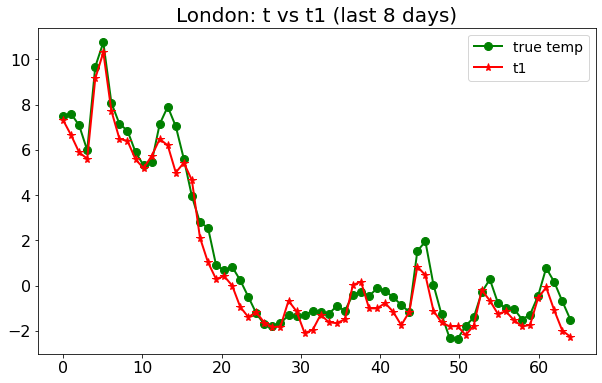

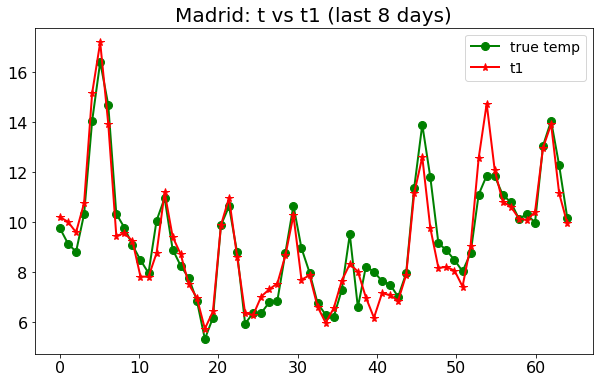

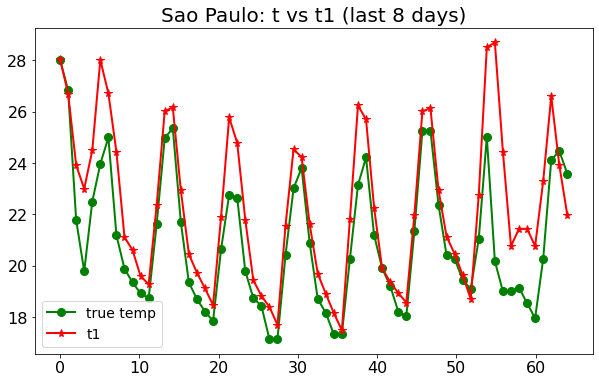

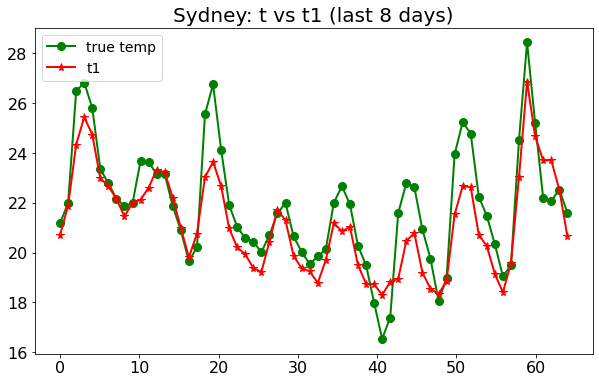

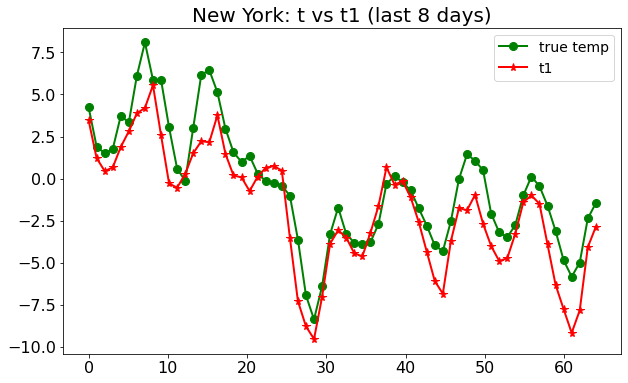

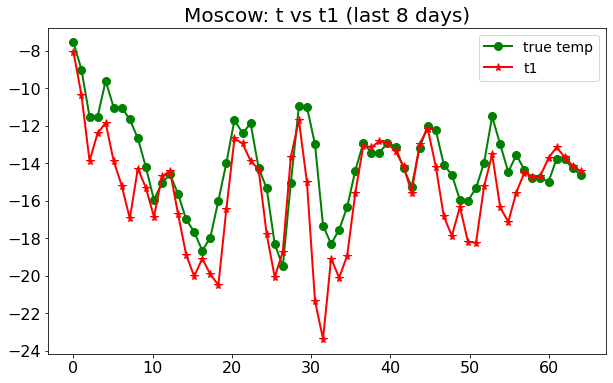

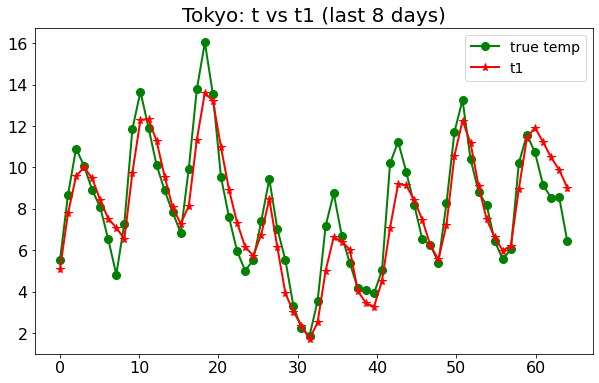

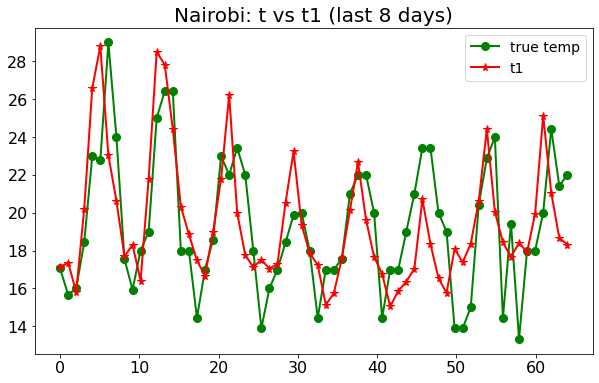

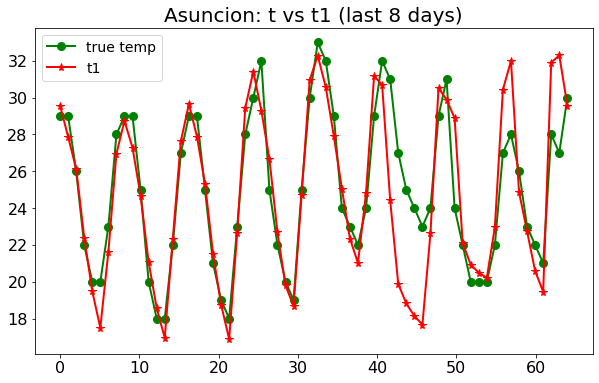

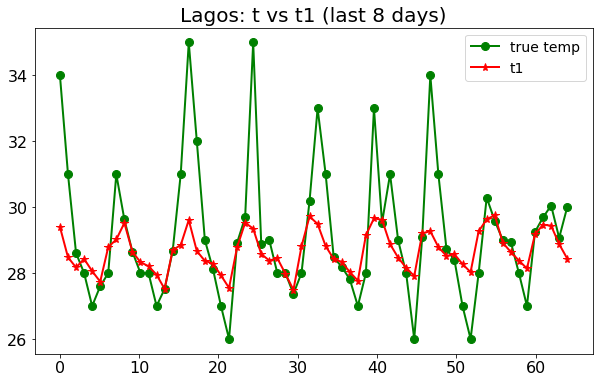

In [17]:
for city in rconf.cities.values():
    plot_true_vs_forecast(city, 't1', 8)

<a id="metrics_comparison"></a>
## Metrics comparison

In all cases, `medae < mae < rmse`

In [18]:
def plot_metrics(city: rconf.City):
    files = rdq.load_csv_files(city)
    # plt.rcParams['figure.figsize'] = (7,3)
    x = np.linspace(0,1,5)
    axes= plt.axes()
#     plt.style.use('classic')
    axes.set_xticks(x)
    axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
    plt.plot(x, files["metrics_df"]['mae'], label='mae', color='blue', marker='o')
    plt.plot(x, files["metrics_df"]['rmse'], label='rmse', color='grey', marker='^')
    plt.plot(x, files["metrics_df"]['medae'], label='medae', color='red', marker='*')
    plt.title(f"metrics - {city_name[city.name]}")
    plt.legend()
    plt.show()

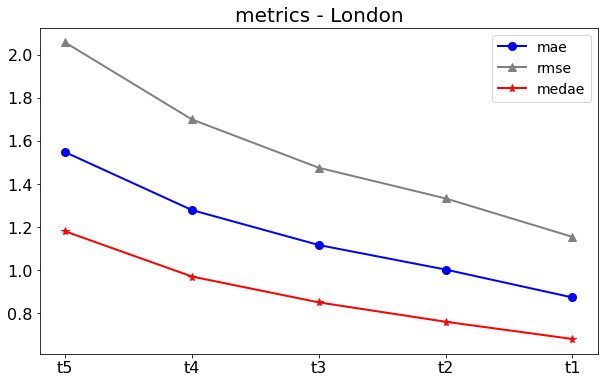

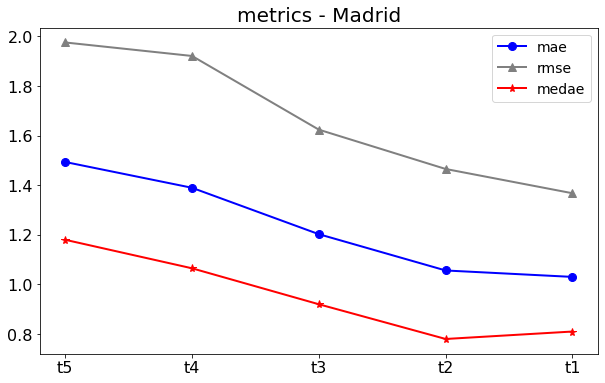

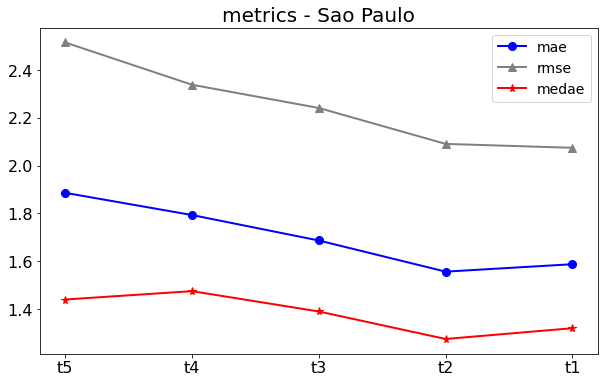

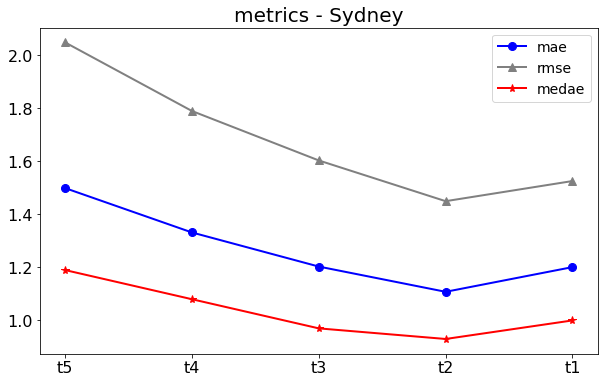

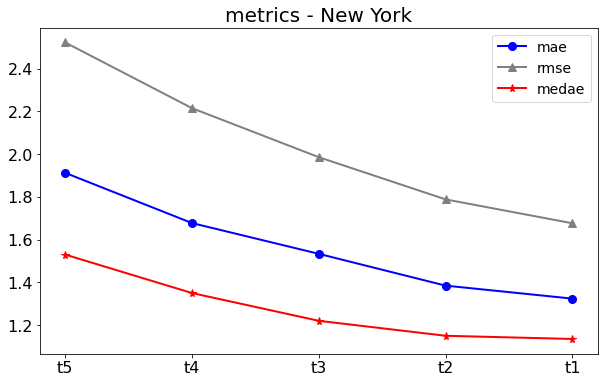

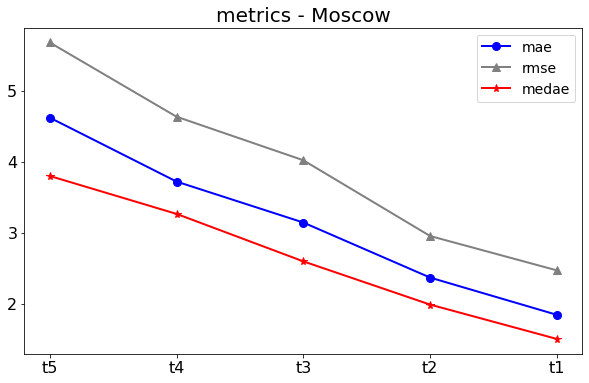

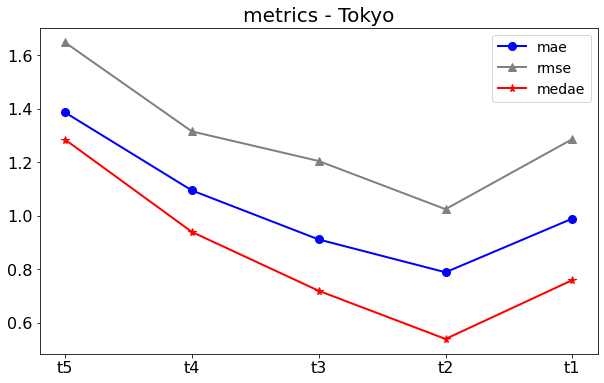

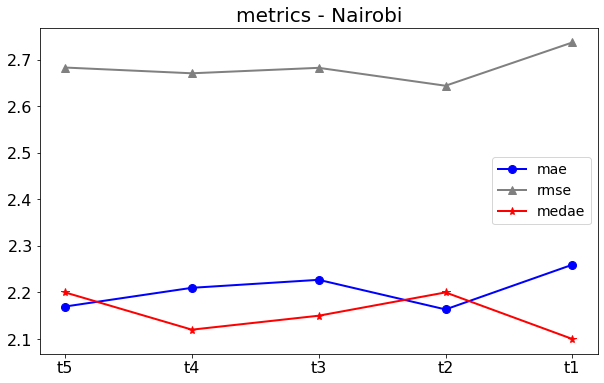

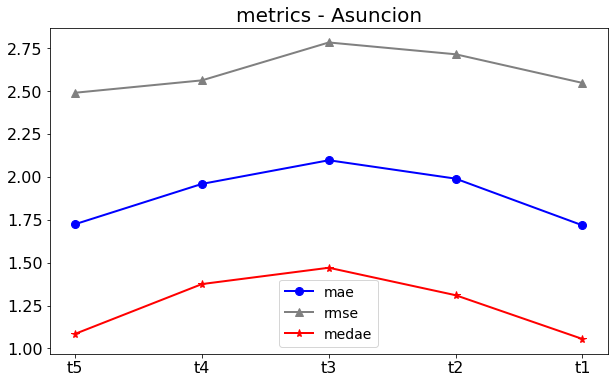

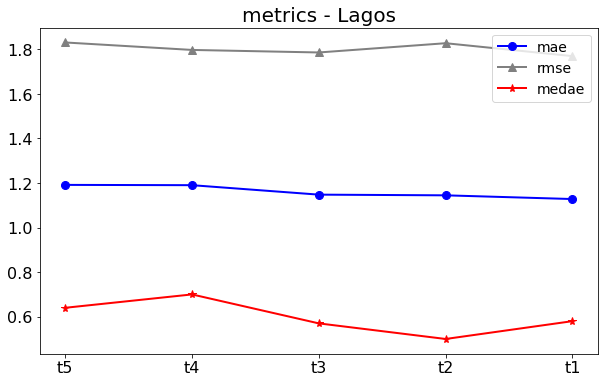

In [19]:
for city in rconf.cities.values():
    plot_metrics(city)

In [20]:
def plot_scaled_error(city: rconf.City):
    files = rdq.load_csv_files(city)
    x = np.linspace(0,1,5)
    axes= plt.axes()
    axes.set_xticks(x)
    axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
    plt.plot(x, files["metrics_df"]['mase'], label='mase', color='blue', marker='o')
    plt.plot(x, files["metrics_df"]['mase1y'], label='mase1y', color='black', marker='*')
#     plt.plot(x, df["metrics_df"]['mase1y_avg'], label='mase1y_avg', color='black', marker='o')
    plt.plot(x, np.ones(5), label='1', color='red')
    plt.title(f"Mean Absolute Scaled Error - {city_name[city.name]}")
    plt.legend()
    plt.show()
    

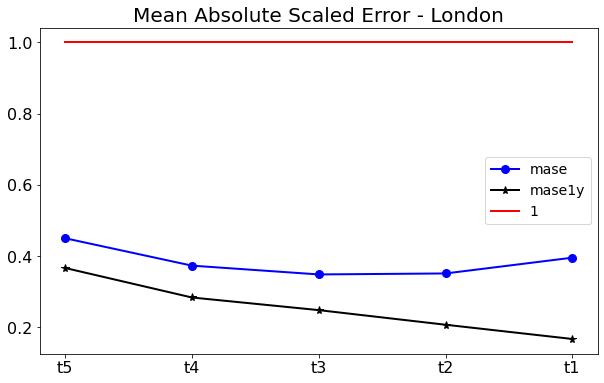

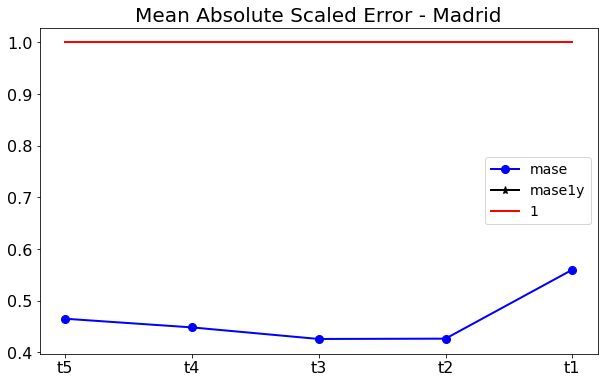

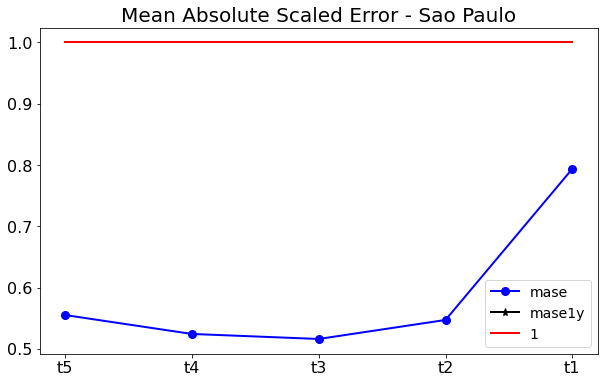

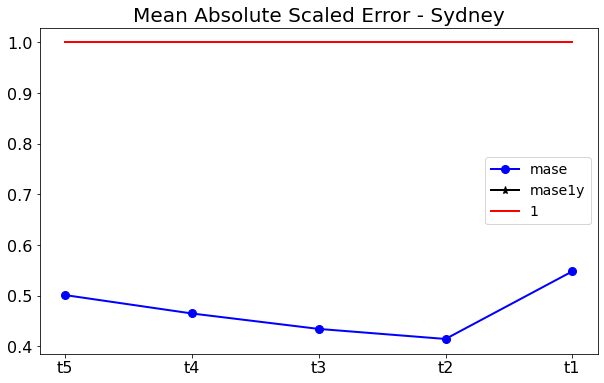

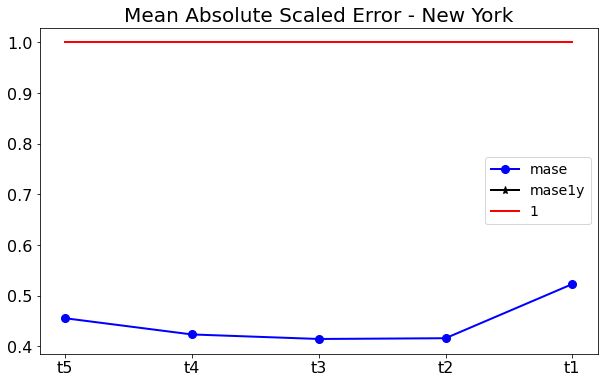

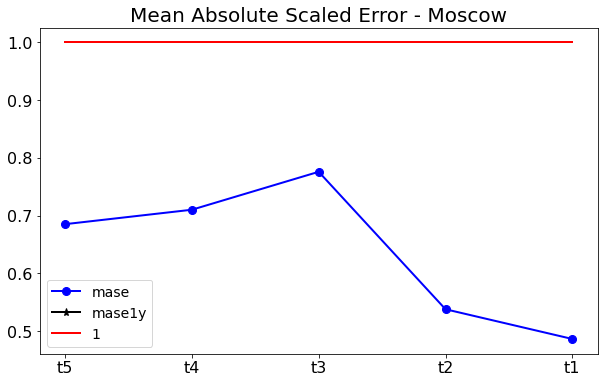

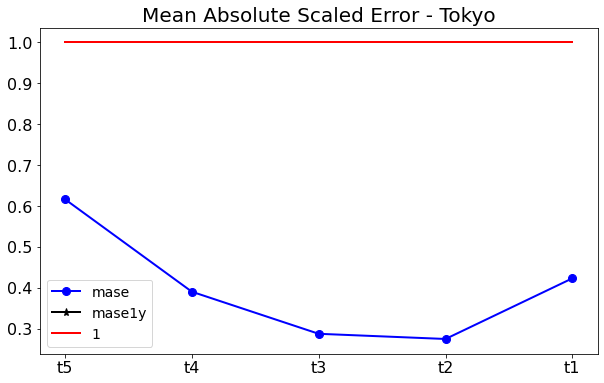

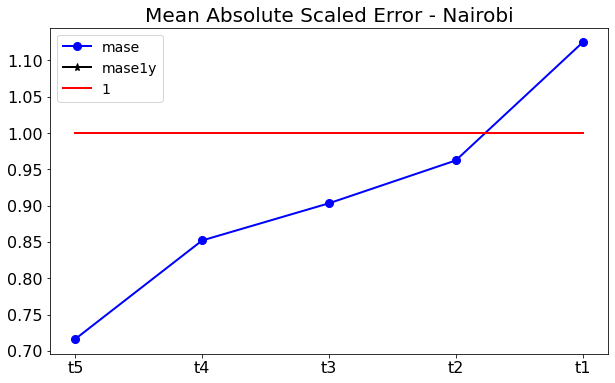

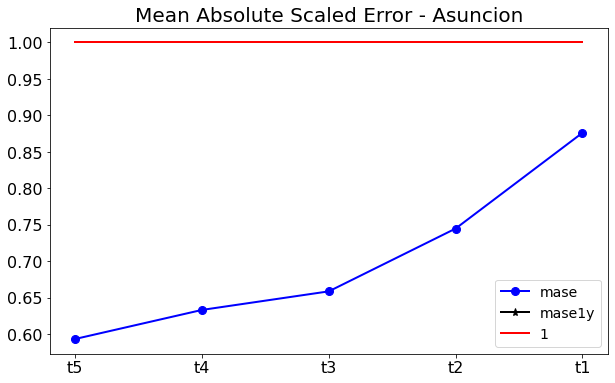

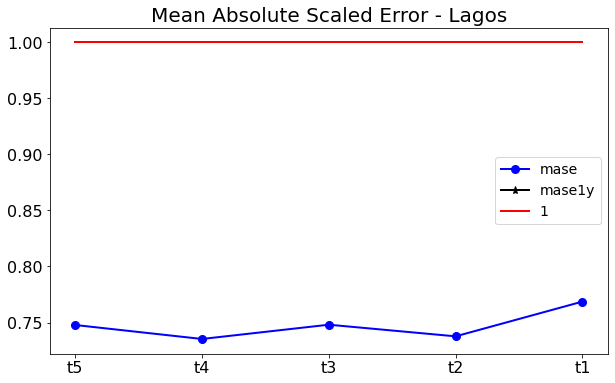

In [21]:
for city in rconf.cities.values():
    plot_scaled_error(city)

<a id="cities_comparison"></a>
## Cities comparison

In [28]:
def plot_cities(metric):
    # plt.rcParams['figure.figsize'] = (7,3)
    colors = ['blue', 'red', 'green', 'black', 'purple']
    x = np.linspace(0,1,5)
    axes= plt.axes()
    axes.set_xticks(x)
    axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
    idx = 0
#     plt.plot(x, np.ones(5), label='1', color='red')
    for city in rconf.cities.values():
        files = rdq.load_csv_files(city)    
        plt.plot(x, files["metrics_df"][metric], label=city_name[city.name], marker='o')
        idx += 1
    plt.title(metric)
    plt.legend()
    plt.show()

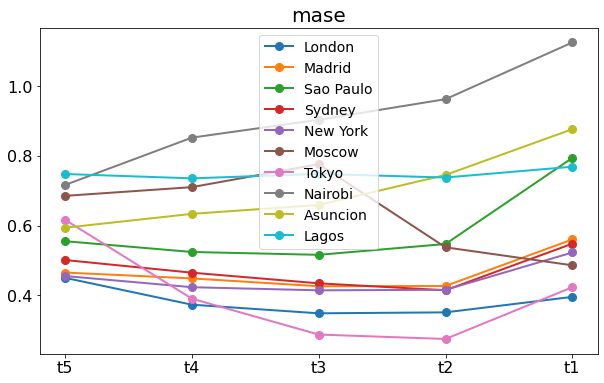

In [29]:
plot_cities('mase')

<a id="results"></a>
# Results